# Replication code for Efficient Concentration with Gaussian Approximation (Figures 1-3)

## Set up environment

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from math import sqrt
from scipy.stats import kstwo
from ttictoc import tic,toc
import os
from efficient import quantile_bound
from ebe import ebe_beta
from bounds import (
    hoeffding_quantile, asymptotic_quantile, berry_esseen_quantile_rw,
    emp_bernstein_quantile, bernstein_quantile, berry_esseen_quantile,
    nonuniform_berry_esseen_quantile, bentkus_quantile, emp_bentkus_quantile,
    feller_quantile
)

from helpers import savefig
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import pickle

## Plot quantile bounds

In [2]:
def plot_quantile_bounds(deltas, ns, sigs, R, two_sided, 
                         inefficient=True, efficient=True, 
                         verbose=False, recompute=False):
    """Displays and returns a len(sigs) by ns.shape[1] matrix of quantile bound
    plots

    For each sample size, standard deviation pair (n,sig)=(ns[ii,jj],sigs[ii]),
    plots quantile bounds q(delta) satisfying P(|S| > q(delta)) <= delta
    if two-sided or P(S > q(delta)) <= delta otherwise, for each
    quantile probability delta in deltas.
    Here S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i] represents any sum
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    Args:
      deltas - Iterable (e.g., list or array) of quantile probabilities delta
      ns - num_rows by num_cols array of sample sizes
      sigs - Iterable (e.g., list or array) of num_rows standard deviations
      R - Boundedness parameter
      two_sided - Plot two-sided quantile bounds?
      inefficient - Plot inefficient quantile bounds?
      efficient - Plot efficient quantile bounds?
      verbose - Verbosity parameter for quantile_bound function
      recompute - Recompute all quantile bounds even if previously cached on disk?

    Returns: Plotted figure
    """
    plt.close('all')
    # Display matrix of plots with one row for each value of R and one column
    # for each value of n
    plt.rcParams['font.size'] = '16'
    num_rows = len(sigs)
    num_cols = ns.shape[1]
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols,
                           sharey='row',
                           figsize=(num_cols*4,num_rows*4))
    # Create directory for results
    results_dir = "quantile_results"
    os.makedirs(results_dir, exist_ok=True)
    for ii in range(num_rows):
        sig = sigs[ii]
        for jj in range(num_cols):
            # Create dictionary to store Wasserstein values for this R,n
            # combination
            cache = {}
            n = ns[ii,jj]

            if num_rows > 1 and num_cols > 1:
                subplt = ax[ii,jj]
            elif num_rows == 1 and num_cols == 1:
                subplt = ax
            elif num_rows > 1:
                subplt = ax[ii]
            else:
                subplt = ax[jj]
            one_minus_deltas = [1-delta for delta in deltas]
            hoeff_qs = [hoeffding_quantile(delta,R=R,two_sided=two_sided) for delta in deltas]
            if inefficient:
                subplt.plot(one_minus_deltas, hoeff_qs, label = "Hoeffding",
                            #linestyle='dotted',
                            color='tab:orange',
                            marker='^')
                subplt.plot(one_minus_deltas, [bernstein_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas], label = "Bernstein",
                            #linestyle='dotted',
                            color='tab:green',
                            marker='o')
                subplt.plot(one_minus_deltas, [bentkus_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas], label = "Bentkus",
                      #linestyle='dotted',
                      color='black',
                      marker='v', zorder=0.4)
            if efficient:
                be_qs = [berry_esseen_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas]
                nube_qs = [nonuniform_berry_esseen_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas]
                feller_qs = [feller_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas]
                # Take the minimum with Hoeffding bound
                be_qs = [min(be_qs[q], hoeff_qs[q]) for q in range(len(be_qs))]
                nube_qs = [min(nube_qs[q], hoeff_qs[q]) for q in range(len(nube_qs))]
                feller_qs = [min(feller_qs[q], hoeff_qs[q]) for q in range(len(feller_qs))]
                # Use lower zorder to send these lines to the back
                subplt.plot(one_minus_deltas, be_qs, label = "Berry-Esseen",
                            #linestyle='dotted',
                            color='tab:purple',
                            marker='<', zorder=0.6) 
                subplt.plot(one_minus_deltas, nube_qs, label = "Non-uniform Berry-Esseen",
                        #linestyle='dotted',
                        color='tab:pink',
                        marker='>', zorder=0.5) 
                subplt.plot(one_minus_deltas, feller_qs, label = "Feller-Cramér",
                        #linestyle='dotted',
                        color='tab:olive',
                        marker='v') 
            def quantile(delta):
                # Check whether previously computed value is available on disk
                filename = os.path.join(
                    results_dir,
                    f"delta{delta}-n{n}-sig{sig}-R{R}-two{two_sided}.pkl")

                if (not recompute) and os.path.isfile(filename):
                    with open(filename, "rb") as f:
                        return pickle.load(f)
                else:
                    q = quantile_bound(delta, n=n, sig=sig, R=R,
                                       verbose=verbose, cache=cache,
                                       two_sided=two_sided)

                    # Save result to disk
                    with open(filename, "wb") as f:
                        pickle.dump(q, f, protocol=pickle.HIGHEST_PROTOCOL)
                    return q
            subplt.plot(one_minus_deltas, [quantile(delta) for delta in deltas], label = "Efficient (Ours)",
                        #linestyle='dashed',
                        color='tab:blue',
                        marker='D')
            subplt.plot(one_minus_deltas, [asymptotic_quantile(delta,sig=sig,two_sided=two_sided) for delta in deltas], label = "Asymptotic",
                        #linestyle='solid',
                        color='tab:red',
                        marker='s')
            if jj == 0:
                if two_sided:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $|S_n|$',fontsize=16)
                else:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $S_n$',fontsize=16)
            subplt.set_xlabel(r'$1-\delta$',fontsize=16)
            subplt.set_title(fr'n = {n}, $\sigma$ = {sig}, R = {R}',fontsize=16)
            # # if jj == num_cols-1 and ii == num_rows-1:
            # #     subplt.legend()#loc='center right')
            if True:
                if False and ii == 1:
                    subplt.set_ylim(top=1.15)
                elif ii == 2:
                    subplt.set_ylim(bottom=.35,top=.75)

    # Add a single figure-level legend
    # Use a list of handles (e.g., from a single plot) and labels
    handles, labels = subplt.get_legend_handles_labels()
    legend_cols = 4 if (inefficient and efficient) else 3
    bbox = (0.531, -0.065) if efficient else (0.521, -0.065)
    fig.legend(handles, labels, loc='lower center', ncol=legend_cols, bbox_to_anchor=bbox)

    fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()

    return fig

gmin=0.99 at t=1.0303317214195602
gmin=0.9844444444444445 at t=0.9676718602899304
gmin=0.9788888888888889 at t=0.9223965726573997
gmin=0.9733333333333334 at t=0.8865451116897596
gmin=0.9677777777777777 at t=0.8566571926158604
gmin=0.9622222222222222 at t=0.8309030937061634
gmin=0.9566666666666667 at t=0.8081931167053625
gmin=0.9511111111111111 at t=0.7878237589186758
gmin=0.9455555555555556 at t=0.7693134356239406
gmin=0.94 at t=0.7523174432605004
gmin=0.99 at t=1.0303317214195602
gmin=0.9844444444444445 at t=0.9676718602899304
gmin=0.9788888888888889 at t=0.9223965726573997
gmin=0.9733333333333334 at t=0.8865451116897596
gmin=0.9677777777777777 at t=0.8566571926158604
gmin=0.9622222222222222 at t=0.8309030937061634
gmin=0.9566666666666667 at t=0.8081931167053625
gmin=0.9511111111111111 at t=0.7878237589186758
gmin=0.9455555555555556 at t=0.7693134356239406
gmin=0.94 at t=0.7523174432605004
gmin=0.99 at t=1.0303317214195602
gmin=0.9844444444444445 at t=0.9676718602899304
gmin=0.9788888

/home/lmackey/gauss_conc/arxiv-src/bounds.py:168: RuntimeWarning: overflow encountered in exp
  1., np.exp(exp_arg) + np.exp(exp_arg2))
/home/lmackey/gauss_conc/arxiv-src/bounds.py:168: RuntimeWarning: overflow encountered in add
  1., np.exp(exp_arg) + np.exp(exp_arg2))


gmin=0.94 at t=0.7523174432605004
gmin=0.99 at t=0.7727487910646701
gmin=0.9844444444444445 at t=0.7257538952174477
gmin=0.9788888888888889 at t=0.6917974294930498
gmin=0.9733333333333334 at t=0.6649088337673197
gmin=0.9677777777777777 at t=0.6424928944618953
gmin=0.9622222222222222 at t=0.6231773202796225
gmin=0.9566666666666667 at t=0.6061448375290218
gmin=0.9511111111111111 at t=0.5908678191890069
gmin=0.9455555555555556 at t=0.5769850767179554
gmin=0.94 at t=0.5642380824453752
gmin=0.99 at t=0.7727487910646701
gmin=0.9844444444444445 at t=0.7257538952174477
gmin=0.9788888888888889 at t=0.6917974294930498
gmin=0.9733333333333334 at t=0.6649088337673197
gmin=0.9677777777777777 at t=0.6424928944618953
gmin=0.9622222222222222 at t=0.6231773202796225
gmin=0.9566666666666667 at t=0.6061448375290218
gmin=0.9511111111111111 at t=0.5908678191890069
gmin=0.9455555555555556 at t=0.5769850767179554
gmin=0.94 at t=0.5642380824453752
gmin=0.01426379051745988 at t=0.950681793814973
gmin=0.0087082

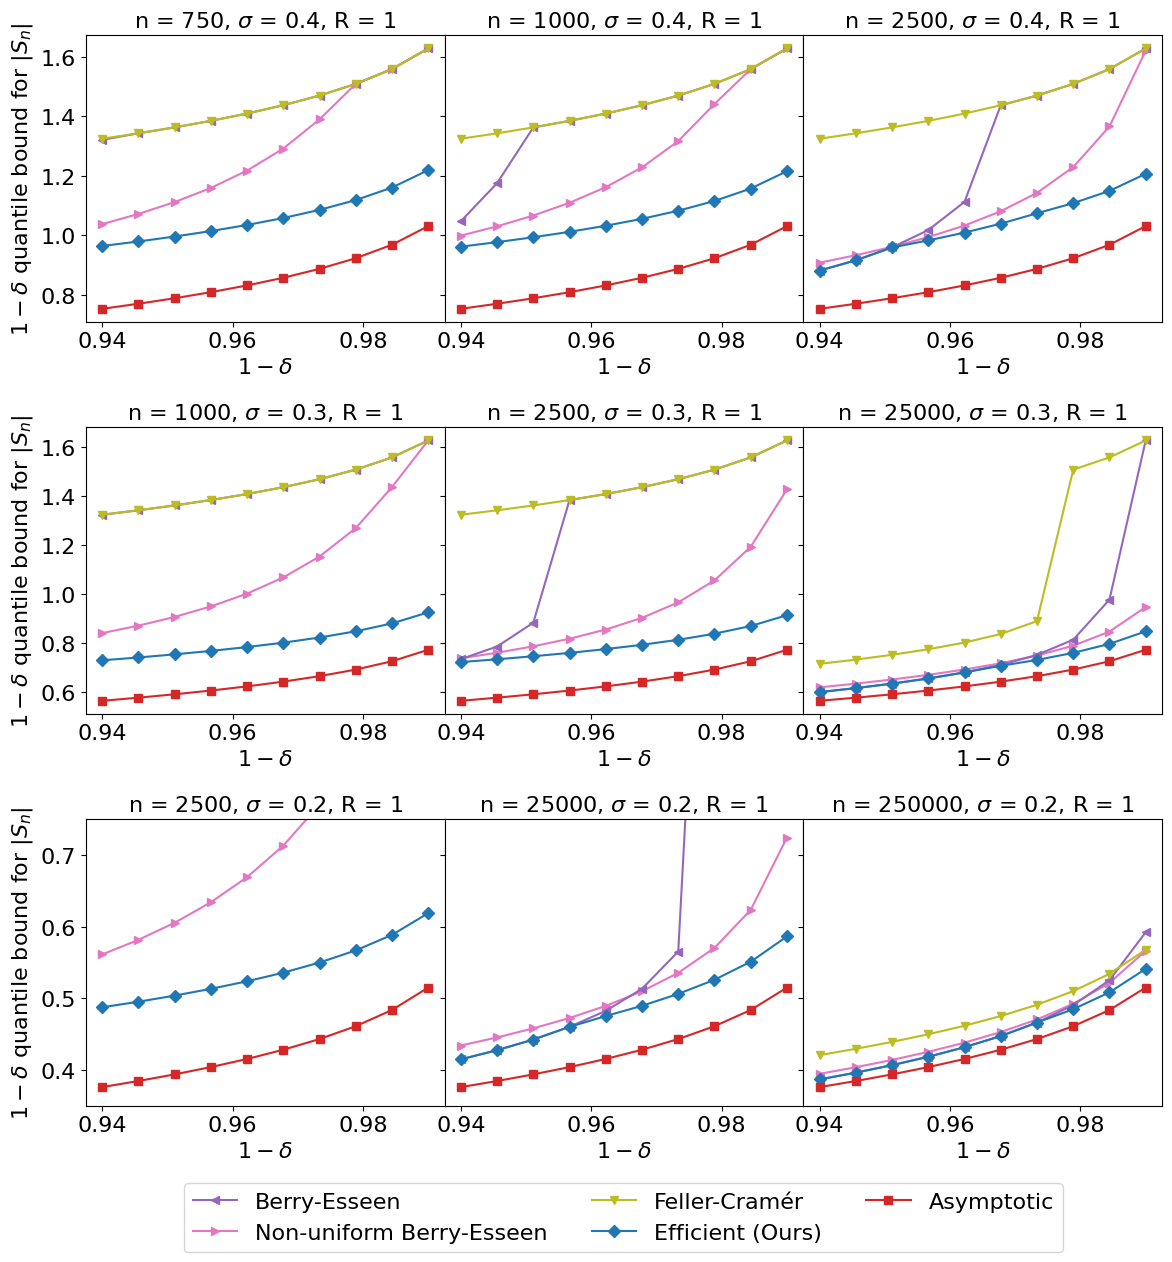

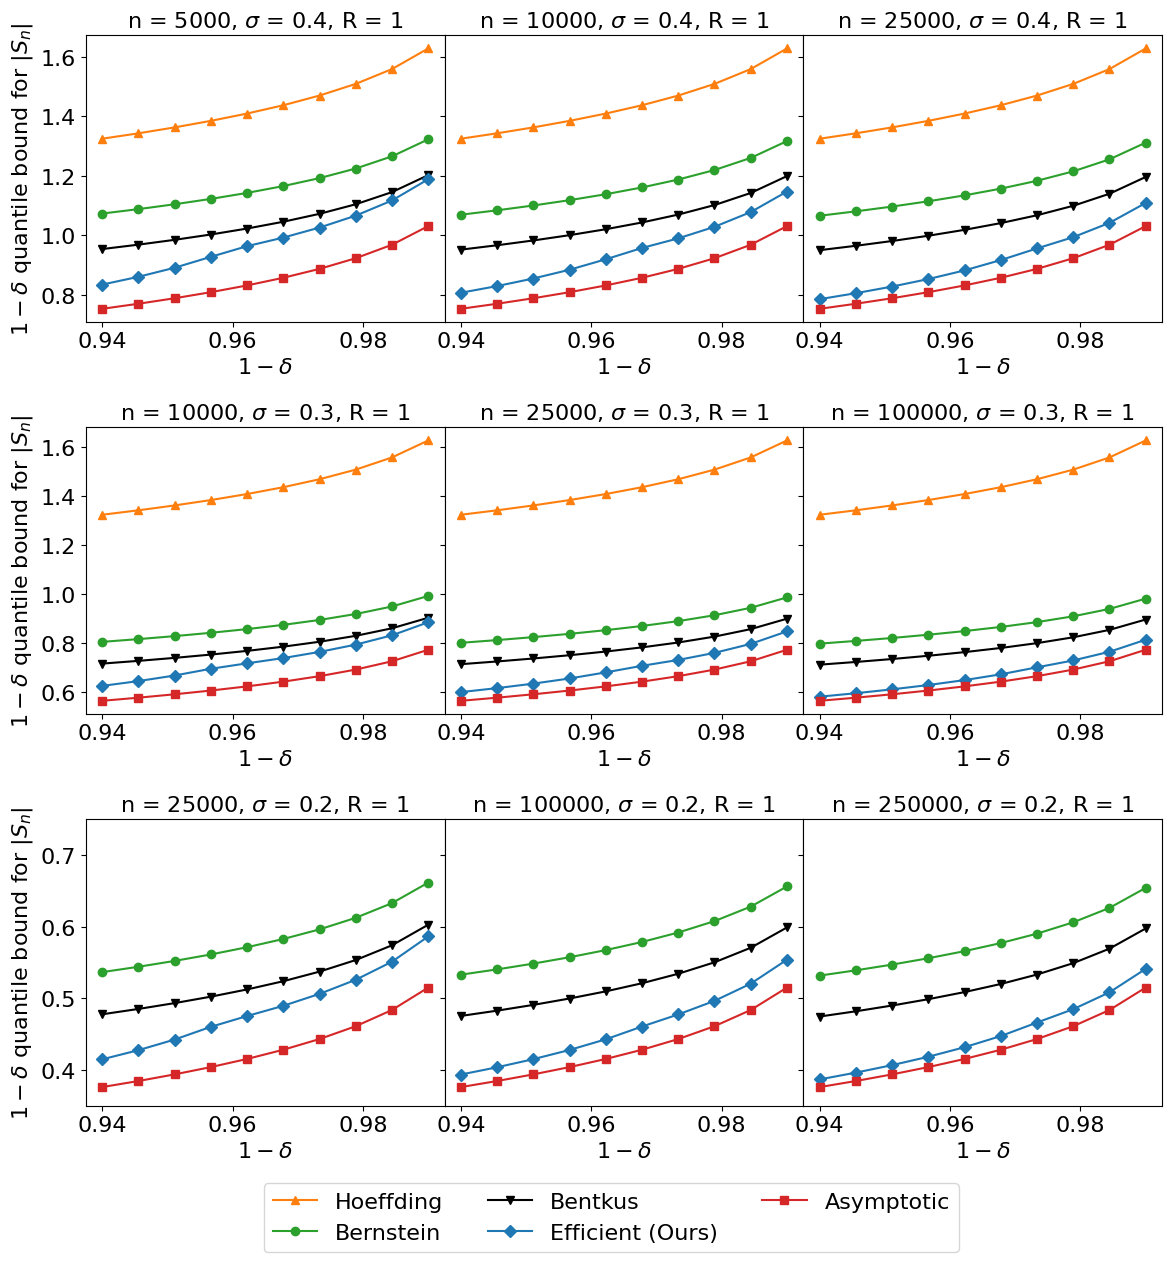

In [3]:
#%%script false --no-raise-error
# Plot quantile bounds
plt.clf()
R = 1
sigs = [.4 * R, .3 * R, .2 * R]
deltas = np.linspace(0.01, 0.06, num=10)
two_sided = True
verbose = False
recompute = False
for inefficient, efficient in [(False, True), (True, False)]:
    if inefficient:
        ns = np.vstack((
            np.array([5000, 10000, 25000]),
            np.array([10000, 25000, 100000]),
            np.array([25000, 100000, 250000])
        ))
    else:
        ns = np.vstack((
            np.concatenate(([750, 1000], 25 * (np.power(10, range(2,3))))),
            np.concatenate(([1000], 25 * (np.power(10, range(2,4))))),
            25 * (np.power(10, range(2,5)))
        ))

    quantile_fig = plot_quantile_bounds(deltas, ns, sigs, R, two_sided,
                                        inefficient=inefficient,
                                        efficient=efficient, verbose=verbose,
                                        recompute=recompute)
    # Save quantile bounds figure to file
    savefig(quantile_fig,f"quantile_bounds_inefficient{inefficient}_efficient{efficient}_twosided{two_sided}_{np.min(ns)}.pdf")
    

## Plot empirical variance quantile bounds

In [ ]:
def rw_sig_est(delta, n, sighat=1, R=1):
    """Returns upper and lower estimates for the standard deviation sig of n
    independent and identically distributed W_i in [0, R]
    based on the empirical variance,
    sighat^2 = (1/n) sum_i (W_i - (1/n) sum_i W_i))^2.

    The estimates (sig_lower, sig_upper) satisfy sig_lower <= sig <= sig_upper
    with probability at least 1-delta and are based on Lemma 4.2 of
    Romano and Wolf - Finite Sample Nonparametric Inference and Large Sample
    Efficiency.
    """
    # Quantile of the Kolmogorov-Smirnov two-sided statistic
    # (without sqrt(n) scaling).
    # That is, quantile of sup_x |F(x) - Fhat(x)|
    # for F the CDF of a random variable on [0,1] and Fhat is an empirical CDF
    # based on n iid draws from that distribution
    c_n = kstwo.ppf(1-delta, n)
    offset = 3 * c_n
    # Derive Romano-Wolf-based upper and lower estimates by
    # considering variables W' = W/R in [0,1]
    # with sig(W') = sig(W)/R and then rescaling overall bound by R
    sighat_over_R_sqd = ((sighat / R) ** 2)
    sig_upper = R * min(.5, sqrt(sighat_over_R_sqd  + offset))
    sig_lower = R * sqrt( max(0, sighat_over_R_sqd - offset) )
    return (sig_lower, sig_upper)

def plot_emp_quantile_bounds(deltas, ns, beta_params, R, two_sided=True, seed=0,
                             verbose=False, bounds=['hoeff','eff','rw','bern','bentkus'],
                             recompute=False):
    """Displays and returns a len(beta_params) by ns.shape[1] matrix of empirical 
    quantile bound plots

    For each sample size, beta pair
    (n,beta)=(ns[ii,jj],betas[ii]), plots empirical quantile bounds q(delta)
    satisfying P(|S| > q(delta)) <= delta for each quantile probability delta
    in deltas.
    Here S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i] where the W_i variables
    are sampled independently from a Beta(beta, beta) * R distribution.

    Args:
      deltas - Iterable (e.g., list or array) of quantile probabilities delta
      ns - Iterable (e.g., list or array) of sample sizes
      beta_params - Iterable (e.g., list or array) of (a,b) pairs for Beta(a,b) distribution
      R - Boundedness parameters
      two_sided - Plot two-sided quantile bounds?
      seed - Random number generator seed for generating random variables
      verbose - Verbosity parameter for emp_quantile_bound function
      bounds - List of optional bounds to plot; valid values are
        'hoeff' for Hoeffding, 'rw' for Romano-Wolf, 'eff' for efficient,
        'bern' for Bernstein, 'bentkus' for Bentkus
      recompute - If False, attempt to load previously saved 'eff' bounds
        from disk; otherwise, recompute 'eff' bounds

    Returns: Plotted figure
    """
    plt.close('all')

    # Display matrix of plots with one row for each value of R and one column for each
    # value of n
    plt.rcParams['font.size'] = '16'
    num_rows = len(beta_params)
    num_cols = ns.shape[1]
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols,
                           sharey='row',
                           figsize=(num_cols*4,num_rows*4))
    # Create directory for results
    results_dir = "emp_quantile_results"
    os.makedirs(results_dir, exist_ok=True)
    for ii in range(num_rows):
        a, b = beta_params[ii]
        for jj in range(num_cols):
            n = ns[ii,jj]
            sqrt_n = sqrt(n)
            print(f"plotting n={n},a={a},b={b}")
            tic()
            # Sample iid sequence
            rng_gen = np.random.default_rng(seed)
            W = rng_gen.beta(a, b, size=n) * R
            # Compute empirical standard deviation
            sighat = W.std(ddof=0)
            def romano_wolf_quantile(delta):
                # Romano-Wolf-based upper and lower estimates for sigma
                b_n = delta * asymptotic_quantile(
                    delta,sig=1,two_sided=two_sided)/sqrt_n
                sig_lower, sig_upper = rw_sig_est(b_n, n, sighat=sighat, R=R)
                if sig_lower <= 0:
                    bound_val = np.inf
                else:
                    # Evaluate Berry Esseen bound as if sig_lower was true sigma
                    q_a = berry_esseen_quantile_rw(delta-b_n, n, sig=sig_lower,
                                                   R=R, two_sided=two_sided)
                    # Rescale quantile bound appropriately
                    bound_val = q_a * sig_upper / sig_lower
                # Compare with Hoeffding quantile after accounting for sigma 
                # estimation union bound
                return min(bound_val,
                           hoeffding_quantile(delta-b_n, R=R, two_sided=two_sided))
            # Dictionary to store Wasserstein distance results across delta values
            cache = {}
            def emp_quantile(delta):
                # Check whether previously computed value is available on disk
                filename = os.path.join(
                    results_dir,
                    f"delta{delta}-n{n}-a{a}-b{b}-R{R}-two{two_sided}-seed{seed}.pkl")

                if (not recompute) and os.path.isfile(filename):
                    with open(filename, "rb") as f:
                        return pickle.load(f)
                else:
                    q = ebe_beta(delta, n, a=a, b=b, seed=seed, recompute=recompute,
                                 R=R, two_sided=two_sided, verbose=verbose, cache = cache)

                    # Save result to disk
                    with open(filename, "wb") as f:
                        pickle.dump(q, f, protocol=pickle.HIGHEST_PROTOCOL)
                    return q

            if num_rows > 1 and num_cols > 1:
                subplt = ax[ii,jj]
            elif num_rows == 1 and num_cols == 1:
                subplt = ax
            elif num_rows > 1:
                subplt = ax[ii]
            else:
                subplt = ax[jj]
            one_minus_deltas = [1-delta for delta in deltas]

            if 'hoeff' in bounds:
                subplt.plot(one_minus_deltas, [(hoeffding_quantile(delta,R=R,two_sided=two_sided)) for delta in deltas],
                            label = "Hoeffding",
                            #linestyle='dotted',
                            color='tab:orange',
                            marker='^')
            if 'bern' in bounds:
                subplt.plot(one_minus_deltas, [(emp_bernstein_quantile(delta,n,sighat=sighat,R=R,two_sided=two_sided)) for delta in deltas],
                            label = "Empirical Bernstein",
                            #linestyle='dotted',
                            color='tab:green',
                            marker='o')
            if 'bentkus' in bounds:
                # Use lower zorder to send this line to the back
                subplt.plot(one_minus_deltas, [(emp_bentkus_quantile(delta,W,R=R,two_sided=two_sided)) for delta in deltas],
                            label = "Empirical Bentkus",
                            #linestyle='dotted',
                            color='black',
                            marker='v', zorder=0.5)
            if 'rw' in bounds:
                # Use lower zorder to send this line back
                subplt.plot(one_minus_deltas, [(romano_wolf_quantile(delta)) for delta in deltas],
                            label = "Romano-Wolf",
                            #linestyle='dashed',
                            color='tab:purple',
                            marker='>', zorder=0.6)
            if 'eff' in bounds:
                subplt.plot(one_minus_deltas, [(emp_quantile(delta)) for delta in deltas],
                            label = r"Empirical Berry-Esseen (Ours)",
                            #linestyle='dashed',
                            color='tab:blue',
                            marker='D')

            subplt.plot(one_minus_deltas, [(asymptotic_quantile(delta,sig=sighat,two_sided=two_sided)) for delta in deltas],
                        label = "Empirical Asymptotic",
                        #linestyle='solid',
                        #linestyle='dashed',
                        color='tab:red',
                        marker='s', alpha=.7, linewidth=2)

            if jj == 0:
                if two_sided:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $|S_n|$',fontsize=16)
                else:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $S_n$',fontsize=16)
            subplt.set_xlabel(r'$1-\delta$',fontsize=16)
            dist_str = f"Unif([0,{R}])" if a == 1 and b == 1 else (
                f"Beta({a},{b})" + ("" if R == 1 else f", R = {R}"))
            subplt.set_title(fr'n = {n}, ' fr'{dist_str}',fontsize=16)
            # if jj == num_cols-1 and ii == num_rows-1:
            #     subplt.legend()#loc='center right')
            print(f"elasped: {toc()}s")

    # Add a single figure-level legend
    # Use a list of handles (e.g., from a single plot) and labels
    handles, labels = subplt.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5375, -0.065))

    fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()
    return fig

plotting n=750,a=0.2,b=0.3
elapsed: 0.012955824000528082s, [sig_lower,sig_upper]=[0.3302433983202568,0.43627479682195797]

prob=0.0008494621381442369: [sig_lower, sig_upper] = [0.3302433983202568, 0.43627479682195797]
elapsed: 11.574419094991754s, prob=0.0008494621381442369, bound(prob)=1.2340639361312216

elapsed: 0.012723066989565268s, [sig_lower,sig_upper]=[0.33269034987793794,0.4351559476925166]

prob=0.0012244269213881826: [sig_lower, sig_upper] = [0.33269034987793794, 0.4351559476925166]
elapsed: 11.53349137501209s, prob=0.0012244269213881826, bound(prob)=1.1631470287419472

elapsed: 0.012983977008843794s, [sig_lower,sig_upper]=[0.3343307323992099,0.4344016104588112]

prob=0.0015658836251595753: [sig_lower, sig_upper] = [0.3343307323992099, 0.4344016104588112]
elapsed: 11.045371776010143s, prob=0.0015658836251595753, bound(prob)=1.1123678938829344

elapsed: 0.012527529994258657s, [sig_lower,sig_upper]=[0.33452474944081845,0.4338377322423843]

prob=0.0018814509307771541: [sig_lowe

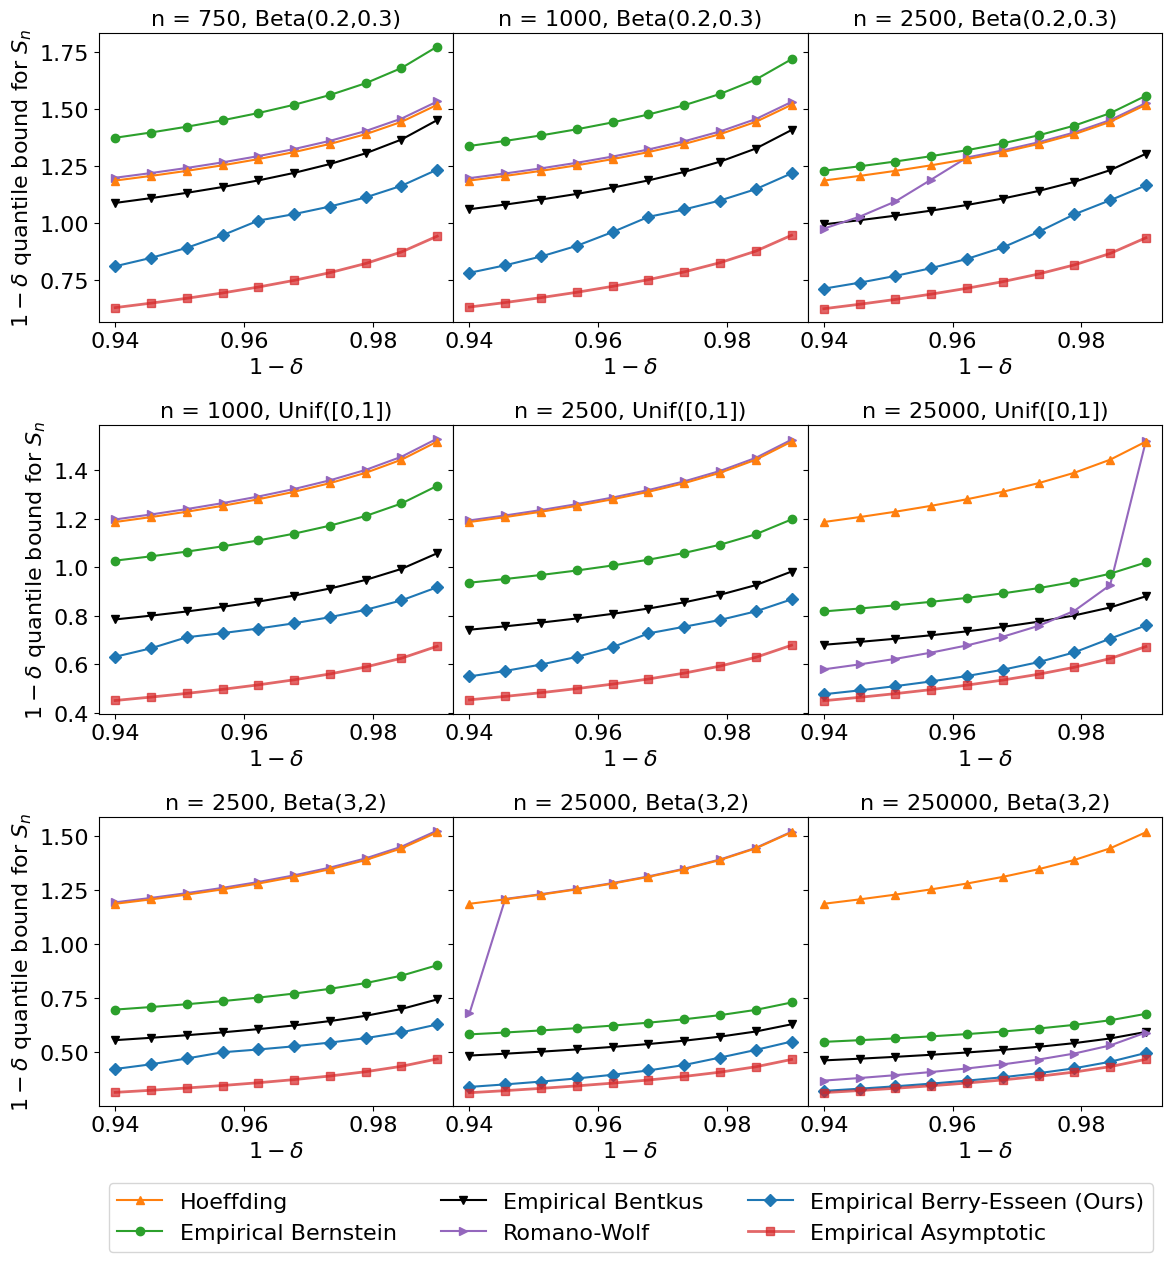

In [4]:
#%%script false --no-raise-error
# Plot empirical quantile bounds
plt.clf()
R = 1
# Parameters for Beta distribution
# standard deviation = sqrt(a*b/(a+b)^2/(a+b+1))
# for a = 3, b = 2, sig = 0.2
# for a = 1, b = 1, sig = 0.288675 (uniform)
# for a = .2, b = .3, sig = 0.4
beta_params=[(.2,.3), (1,1), (3,2)]
ns = np.vstack((
    np.concatenate(([750, 1000], 25 * (np.power(10, range(2,3))))),
    np.concatenate(([1000], 25 * (np.power(10, range(2,4))))),
    25 * (np.power(10, range(2,5)))
))
deltas = np.linspace(0.01, 0.06, num=10)
verbose = True
bounds=['rw','hoeff','eff','bern','bentkus']
two_sided = False
recompute = False
emp_quantile_fig = plot_emp_quantile_bounds(
    deltas, ns, beta_params, R, two_sided=two_sided,
    verbose=verbose, bounds=bounds, recompute=recompute)

In [5]:
#%%script false --no-raise-error
# Save empirical quantile bounds figure to file
savefig(emp_quantile_fig,f"emp_quantile_bounds_twosided{two_sided}.pdf")